In [2]:
import networkx as nx
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [3]:
# network path mushroom_network_final.pkl
with open("mushroom_network_final.pkl", 'rb') as f:
    G_final = pd.read_pickle(f)

In [4]:
# Print basic info about the graph such as number of nodes and edges
print(f"Number of nodes: {G_final.number_of_nodes()}")
print(f"Number of edges: {G_final.number_of_edges()}")

# Average degree
degrees = [val for (node, val) in G_final.degree()]
avg_degree = sum(degrees) / len(degrees)
print(f"Average degree: {avg_degree}")

# Print node attributes of first node
first_node = list(G_final.nodes())[0]
print(f"Attributes of the first node ({first_node}): {G_final.nodes[first_node]}")

Number of nodes: 1101
Number of edges: 8280
Average degree: 15.040871934604905
Attributes of the first node (0): {'label': 'Russula maculata', 'views': 9897, 'genus': 'Russula', 'family': 'Russulaceae', 'community_louvain': 0, 'community_name': 'Russulaceae'}


Calculating centrality metrics...


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


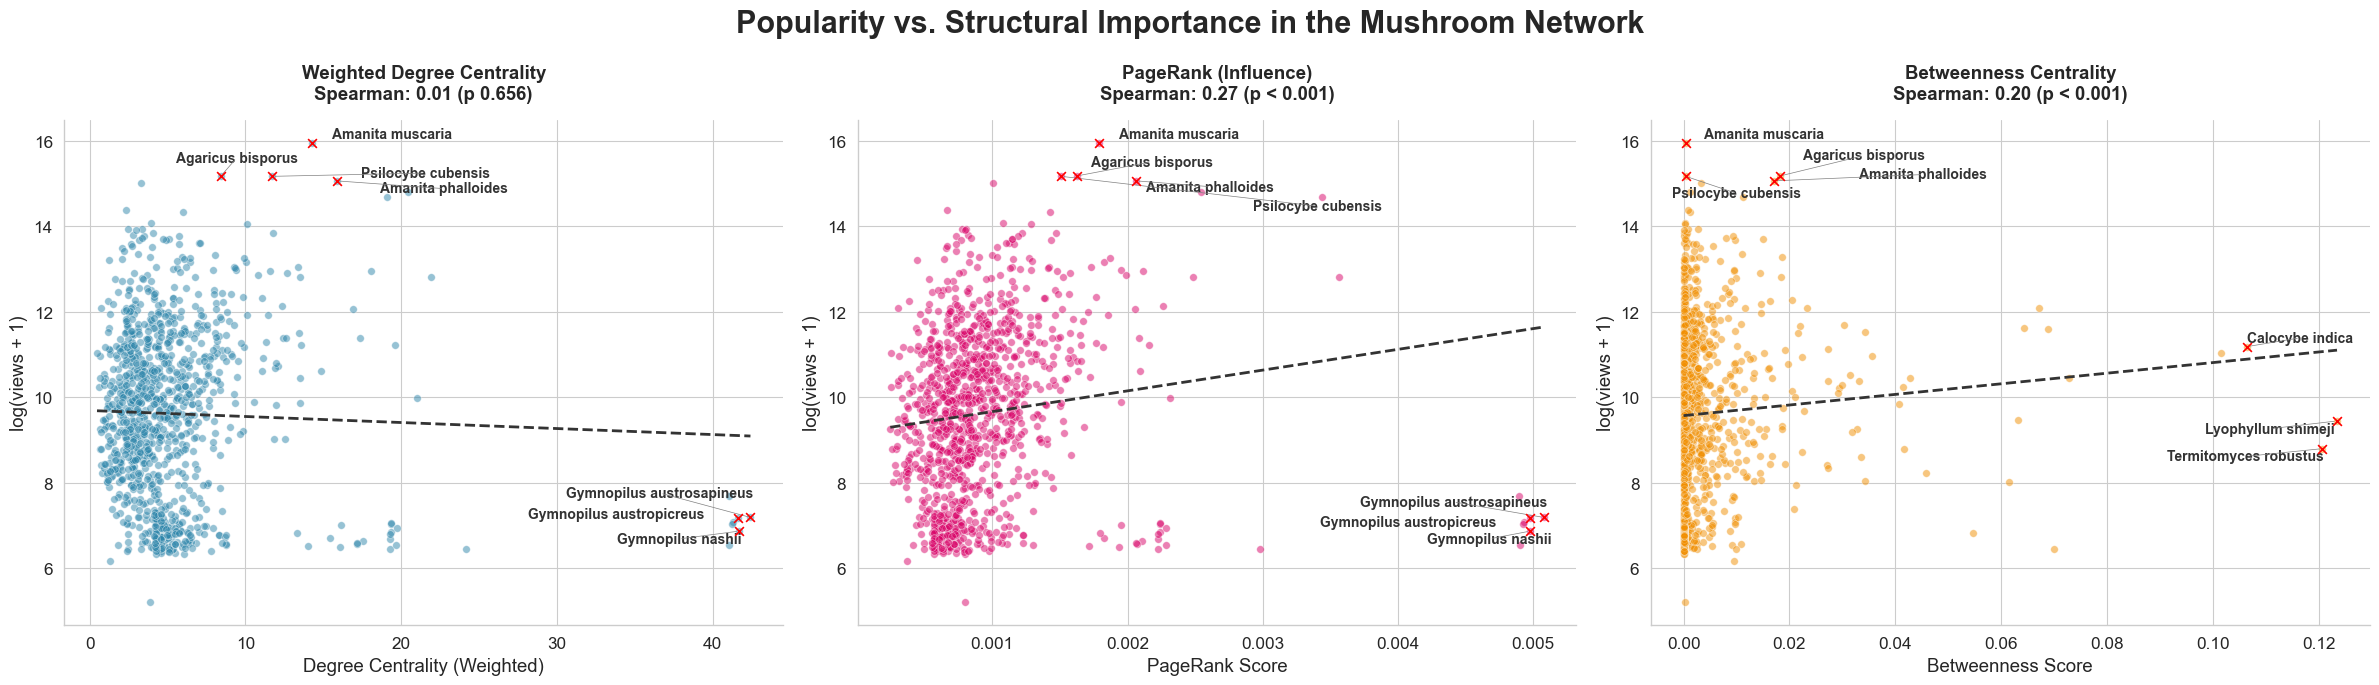


--- Spearman Correlations with Views ---
degree_centrality: 0.0134 (p-value: 6.5642e-01)
pagerank: 0.2721 (p-value: 3.8941e-20)
betweenness: 0.2006 (p-value: 1.8720e-11)
--------------------------------------------------
ANALYSIS RESULTS
--------------------------------------------------
Hidden Gems (High Structural Importance, Low Views):
                           mushroom            family  views  pagerank
node_idx                                                              
550       Gymnopilus novoguineensis  Hymenogastraceae    636  0.002983
516          Gymnopilus longisporus  Hymenogastraceae    635  0.002228
584        Gymnopilus rufopunctatus  Hymenogastraceae    695  0.004900
517             Gymnopilus longipes  Hymenogastraceae    694  0.002286
469            Gymnopilus decoratus  Hymenogastraceae    658  0.001936

--------------------------------------------------
Pop Stars (Low Structural Importance, High Views):
                           mushroom            family   v

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# Try to import adjustText for non-overlapping labels
try:
    from adjustText import adjust_text
    HAS_ADJUST_TEXT = True
except ImportError:
    HAS_ADJUST_TEXT = False
    print("Tip: Run 'pip install adjustText' for perfect label placement.")

# --- 1. LOAD AND PREPARE DATA ---
file_path = "mushroom_network_final.pkl"
with open(file_path, 'rb') as f:
    G = pd.read_pickle(f)

# Extract data
nodes_data = []
for n, attrs in G.nodes(data=True):
    nodes_data.append({
        'node_idx': n,
        'mushroom': attrs.get('label', 'Unknown'),
        'views': attrs.get('views', 0),
        'family': attrs.get('family', 'Unknown'),
        'community': attrs.get('community_name', 'Unknown')
    })
df_res = pd.DataFrame(nodes_data).set_index('node_idx')

# --- 2. CALCULATE METRICS ---
print("Calculating centrality metrics...")

degree_dict = dict(G.degree(weight='weight'))
df_res['degree_centrality'] = df_res.index.map(degree_dict)

pagerank_dict = nx.pagerank(G, weight='weight')
df_res['pagerank'] = df_res.index.map(pagerank_dict)

betweenness_dict = nx.betweenness_centrality(G, weight='weight')
df_res['betweenness'] = df_res.index.map(betweenness_dict)

df_res['log_views'] = np.log1p(df_res['views'])

# --- 3. CONFIGURATION FOR PLOTTING ---
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

metric_settings = {
    'degree_centrality': {
        'title': 'Weighted Degree Centrality',
        'color': '#2E86AB',
        'xlabel': 'Degree Centrality (Weighted)'
    },
    'pagerank': {
        'title': 'PageRank (Influence)',
        'color': '#D90368',
        'xlabel': 'PageRank Score'
    },
    'betweenness': {
        'title': 'Betweenness Centrality',
        'color': '#F18F01',
        'xlabel': 'Betweenness Score'
    }
}

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(top=0.85)

# --- 4. PLOTTING LOOP ---
for i, (metric_key, config) in enumerate(metric_settings.items()):
    ax = axes[i]
    
    # A. Calculate Correlation
    corr, p_val = spearmanr(df_res['views'], df_res[metric_key])
    p_text = "< 0.001" if p_val < 0.001 else f"{p_val:.3f}"
    
    # B. Plot regression without CI
    sns.regplot(
        data=df_res,
        x=metric_key,
        y='log_views',
        ax=ax,
        scatter_kws={'alpha': 0.5, 's': 30, 'edgecolor': 'white', 'linewidth': 0.5},
        line_kws={'color': '#333333', 'linewidth': 2, 'linestyle': '--'},
        color=config['color'],
        ci=None
    )
    
    # C. Titles and Labels
    ax.set_title(f"{config['title']}\nSpearman: {corr:.2f} (p {p_text})",
                 fontweight='bold',
                 pad=15)
    ax.set_ylabel("log(views + 1)")
    ax.set_xlabel(config['xlabel'])
    
    # D. Labeling Outliers
    texts = []
    top_views = df_res.nlargest(4, 'views')
    top_metric = df_res.nlargest(3, metric_key)
    labels_to_plot = pd.concat([top_views, top_metric]).drop_duplicates()

    for idx, row in labels_to_plot.iterrows():
        t = ax.text(
            row[metric_key],
            row['log_views'],
            row['mushroom'],
            fontsize=10,
            weight='bold',
            color='#333333'
        )
        texts.append(t)
        ax.scatter(row[metric_key], row['log_views'], color='red', s=40, zorder=5, marker='x')

    if HAS_ADJUST_TEXT:
        adjust_text(
            texts,
            ax=ax,
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
            expand_points=(1.5, 1.5)
        )

    sns.despine(ax=ax)

fig.suptitle("Popularity vs. Structural Importance in the Mushroom Network",
             fontsize=22,
             weight='bold',
             y=0.98)

plt.tight_layout()
plt.show()

# --- 5. PRINT ANALYSIS ---
df_res['rank_views'] = df_res['views'].rank(pct=True)
df_res['rank_pagerank'] = df_res['pagerank'].rank(pct=True)
df_res['diff'] = df_res['rank_pagerank'] - df_res['rank_views']

metrics = ['degree_centrality', 'pagerank', 'betweenness']
correlations = {}

print("\n--- Spearman Correlations with Views ---")
for metric in metrics:
    corr, p_val = spearmanr(df_res['views'], df_res[metric])
    correlations[metric] = corr
    print(f"{metric}: {corr:.4f} (p-value: {p_val:.4e})")

print("-" * 50)
print("ANALYSIS RESULTS")
print("-" * 50)
print("Hidden Gems (High Structural Importance, Low Views):")
print(df_res.sort_values('diff', ascending=False).head(5)[['mushroom', 'family', 'views', 'pagerank']])

print("\n" + "-" * 50)
print("Pop Stars (Low Structural Importance, High Views):")
print(df_res.sort_values('diff', ascending=True).head(5)[['mushroom', 'family', 'views', 'pagerank']])

Graph loaded: 1101 nodes.
Data points ready: 1101


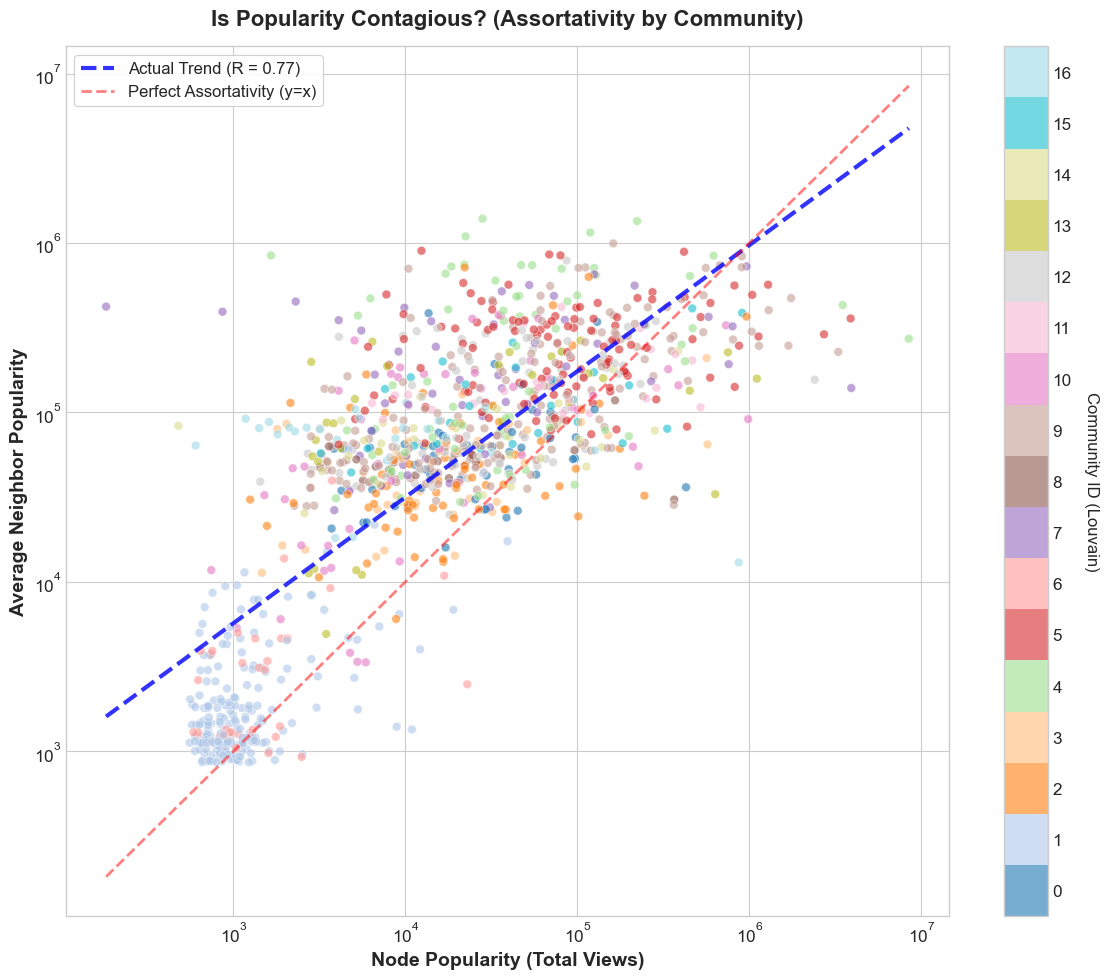

Correlation: 0.7728


In [12]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- 1. LOAD DATA ---
file_path = "mushroom_network_final.pkl"
with open(file_path, 'rb') as f:
    G_final = pd.read_pickle(f)

print(f"Graph loaded: {G_final.number_of_nodes()} nodes.")

# --- 2. EXTRACT DATA DIRECTLY FROM GRAPH ---
x_views = []
y_neighbor_views = []
colors = [] 

# Iterate through nodes in the graph
for node in G_final.nodes():
    # Get Node Attributes
    attrs = G_final.nodes[node]
    my_views = attrs.get('views', 0)
    comm_id = attrs.get('community_louvain', 0) # Default to 0 if missing
    
    # Calculate Neighbor Avg Views
    neighbors = list(G_final.neighbors(node))
    if len(neighbors) > 0 and my_views > 0:
        neighbor_views = [G_final.nodes[n].get('views', 0) for n in neighbors]
        avg_neighbor_views = np.mean(neighbor_views)
        
        # Only append if valid data (log(0) protection)
        if avg_neighbor_views > 0:
            x_views.append(my_views)
            y_neighbor_views.append(avg_neighbor_views)
            colors.append(comm_id)

# Convert lists to numpy arrays for vectorized operations
x_views = np.array(x_views)
y_neighbor_views = np.array(y_neighbor_views)
colors = np.array(colors)

print(f"Data points ready: {len(x_views)}")

# --- 3. CALCULATE STATISTICS ---
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x_views), np.log10(y_neighbor_views))

# --- 4. PLOTTING (Your Improved Version) ---
plt.figure(figsize=(12, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Prepare discrete colormap
unique_comms = np.unique(colors)
n_comms = len(unique_comms)

base = plt.get_cmap('tab20')
# Handle case where n_comms > 20 by cycling or using a larger map
if n_comms > 20:
    base = plt.get_cmap('nipy_spectral')
    
cmap = ListedColormap(base(np.linspace(0, 1, n_comms)))

# Boundaries centered around actual community IDs
boundaries = np.concatenate([
    unique_comms - 0.5,
    [unique_comms[-1] + 0.5]
])

norm = BoundaryNorm(boundaries, cmap.N)

# Scatter
scatter = plt.scatter(
    x_views,
    y_neighbor_views,
    c=colors,
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    s=40,
    edgecolors='white',
    linewidth=0.5
)

# A. Trendline
trendline_x = np.linspace(min(x_views), max(x_views), 100)
trendline_y = 10**(slope * np.log10(trendline_x) + intercept)

plt.plot(
    trendline_x,
    trendline_y,
    'b--',
    linewidth=3,
    alpha=0.8,
    label=f'Actual Trend (R = {r_value:.2f})'
)

# B. Diagonal y=x
lims = [
    min(x_views.min(), y_neighbor_views.min()),
    max(x_views.max(), y_neighbor_views.max())
]

plt.plot(
    lims,
    lims,
    'r--',
    linewidth=2,
    alpha=0.5,
    label='Perfect Assortativity (y=x)'
)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Node Popularity (Total Views)', fontsize=14, fontweight='bold')
plt.ylabel('Average Neighbor Popularity', fontsize=14, fontweight='bold')
plt.title(
    'Is Popularity Contagious? (Assortativity by Community)',
    fontsize=16,
    fontweight='bold',
    pad=15
)

# Discrete colorbar with centered labels
cbar = plt.colorbar(scatter, boundaries=boundaries, ticks=unique_comms)
cbar.set_label('Community ID (Louvain)', rotation=270, labelpad=20, fontsize=12)
cbar.set_ticklabels([str(int(c)) for c in unique_comms])

# Legend
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

print(f"Correlation: {r_value:.4f}")